In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)


import logging
tf.get_logger().setLevel(logging.ERROR)

2023-02-05 13:54:13.730518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-02-05 13:54:13.730536: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Data augmentation

In [5]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=20,var1_u=60,CROP1=CROP,BATCH_SIZE=50)

In [3]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

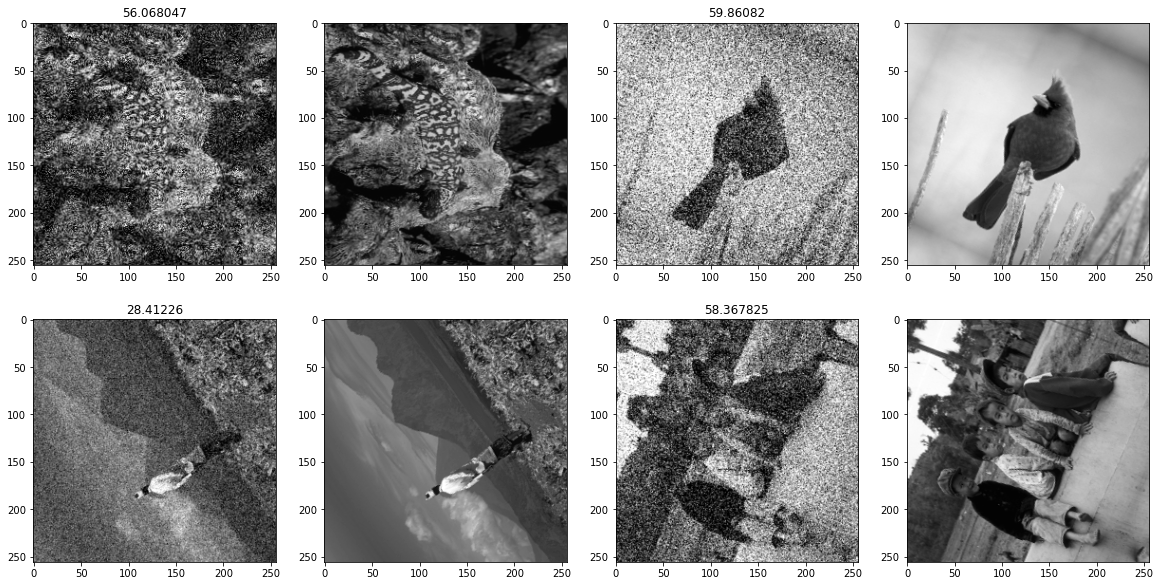

In [4]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs['input']))
        axs[i,2*j].imshow(np.squeeze(xs['input'][_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        axs[i,2*j].set_title(str(np.mean(xs['input_emb'][_])))
        
plt.show()

# Neural networks

In [8]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

## Training

In [6]:
def loss(y_true,y_pred):
    return 1/(tf.image.psnr(y_true,y_pred,1)) + 0.09*(1-tf.image.ssim(y_true,y_pred,1))

In [17]:
typ = "gaussian"
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=1,var1_u=7,CROP1=CROP,BATCH_SIZE=32)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)
    model = get_model("splines",it_lim=4,image_size=image_size,num_classes = num_classes,order=order)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=loss,)
    #model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/splines_{typ}_{num_classes}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
    ]
    
    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=25,
        validation_data=gen_batch_val,
        validation_steps=5,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
    
    np.save(f'./history/splines_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

num_classes:  5
Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 0.1822
Epoch 00001: val_loss improved from inf to 0.03375, saving model to ./checkpoints/splines_gaussian_5
25/25 [==============================] - 21s 742ms/step - loss: 0.1822 - val_loss: 0.0338 - lr: 1.0000e-04
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 0.0908
Epoch 00002: val_loss did not improve from 0.03375
25/25 [==============================] - 18s 710ms/step - loss: 0.0908 - val_loss: 0.0341 - lr: 1.0000e-04
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 0.0378
Epoch 00003: val_loss did not improve from 0.03375
25/25 [==============================] - 18s 704ms/step - loss: 0.0378 - val_loss: 0.0343 - lr: 1.0000e-04
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: -0.4475
Epoch 00004: val_loss did not improve from 0.03375
25/25 [==============================] - 18s 710ms/step - loss: -0.4475 - val_loss: 0.0347 - lr: 1.0000e-04


Epoch 35/50
25/25 [==============================] - ETA: 0s - loss: -0.1221
Epoch 00035: val_loss did not improve from 0.03375
25/25 [==============================] - 18s 719ms/step - loss: -0.1221 - val_loss: 0.0619 - lr: 8.0000e-07
Epoch 36/50
25/25 [==============================] - ETA: 0s - loss: 0.0627
Epoch 00036: val_loss did not improve from 0.03375
25/25 [==============================] - 18s 713ms/step - loss: 0.0627 - val_loss: 0.0811 - lr: 8.0000e-07
Epoch 37/50
25/25 [==============================] - ETA: 0s - loss: 0.0592
Epoch 00037: val_loss did not improve from 0.03375
25/25 [==============================] - 18s 705ms/step - loss: 0.0592 - val_loss: 0.0671 - lr: 8.0000e-07
Epoch 38/50
25/25 [==============================] - ETA: 0s - loss: 0.0583
Epoch 00038: val_loss did not improve from 0.03375
25/25 [==============================] - 18s 708ms/step - loss: 0.0583 - val_loss: 0.0656 - lr: 8.0000e-07
Epoch 39/50
25/25 [==============================] - ETA: 0s -

Epoch 20/50
25/25 [==============================] - ETA: 0s - loss: nan
Epoch 00020: val_loss did not improve from 0.03606
25/25 [==============================] - 19s 745ms/step - loss: nan - val_loss: nan - lr: 2.0000e-05
Epoch 21/50
25/25 [==============================] - ETA: 0s - loss: nan
Epoch 00021: val_loss did not improve from 0.03606

Epoch 00021: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
25/25 [==============================] - 19s 753ms/step - loss: nan - val_loss: nan - lr: 2.0000e-05
Epoch 22/50
25/25 [==============================] - ETA: 0s - loss: nan
Epoch 00022: val_loss did not improve from 0.03606
25/25 [==============================] - 18s 742ms/step - loss: nan - val_loss: nan - lr: 4.0000e-06
Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: nan
Epoch 00023: val_loss did not improve from 0.03606
25/25 [==============================] - 19s 747ms/step - loss: nan - val_loss: nan - lr: 4.0000e-06
Epoch 24/50
25/25 [

Epoch 5/50
25/25 [==============================] - ETA: 0s - loss: 0.0616
Epoch 00005: val_loss did not improve from 0.03626
25/25 [==============================] - 20s 801ms/step - loss: 0.0616 - val_loss: 0.0368 - lr: 1.0000e-04
Epoch 6/50
25/25 [==============================] - ETA: 0s - loss: 0.0544
Epoch 00006: val_loss improved from 0.03626 to 0.03573, saving model to ./checkpoints/splines_gaussian_15
25/25 [==============================] - 20s 807ms/step - loss: 0.0544 - val_loss: 0.0357 - lr: 1.0000e-04
Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.0489
Epoch 00007: val_loss improved from 0.03573 to 0.03503, saving model to ./checkpoints/splines_gaussian_15
25/25 [==============================] - 20s 794ms/step - loss: 0.0489 - val_loss: 0.0350 - lr: 1.0000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.0449
Epoch 00008: val_loss improved from 0.03503 to 0.03476, saving model to ./checkpoints/splines_gaussian_15
25/25 [===

Epoch 39/50
25/25 [==============================] - ETA: 0s - loss: 0.0362
Epoch 00039: val_loss did not improve from 0.03476
25/25 [==============================] - 20s 793ms/step - loss: 0.0362 - val_loss: 0.0367 - lr: 8.0000e-07
Epoch 40/50
25/25 [==============================] - ETA: 0s - loss: 0.0360
Epoch 00040: val_loss did not improve from 0.03476
25/25 [==============================] - 20s 788ms/step - loss: 0.0360 - val_loss: 0.0357 - lr: 8.0000e-07
Epoch 41/50
25/25 [==============================] - ETA: 0s - loss: 0.0359
Epoch 00041: val_loss did not improve from 0.03476
25/25 [==============================] - 20s 788ms/step - loss: 0.0359 - val_loss: 0.0368 - lr: 8.0000e-07
Epoch 42/50
25/25 [==============================] - ETA: 0s - loss: 0.0360
Epoch 00042: val_loss did not improve from 0.03476
25/25 [==============================] - 20s 789ms/step - loss: 0.0360 - val_loss: 0.0358 - lr: 8.0000e-07
Epoch 43/50
25/25 [==============================] - ETA: 0s - l

Epoch 23/50
25/25 [==============================] - ETA: 0s - loss: 0.0368
Epoch 00023: val_loss did not improve from 0.03523
25/25 [==============================] - 20s 806ms/step - loss: 0.0368 - val_loss: 0.0367 - lr: 1.0000e-04
Epoch 24/50
25/25 [==============================] - ETA: 0s - loss: 0.0366
Epoch 00024: val_loss did not improve from 0.03523

Epoch 00024: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
25/25 [==============================] - 21s 827ms/step - loss: 0.0366 - val_loss: 0.0365 - lr: 1.0000e-04
Epoch 25/50
25/25 [==============================] - ETA: 0s - loss: 0.0366
Epoch 00025: val_loss did not improve from 0.03523
25/25 [==============================] - 20s 814ms/step - loss: 0.0366 - val_loss: 0.0361 - lr: 2.0000e-05
Epoch 26/50
25/25 [==============================] - ETA: 0s - loss: 0.0363
Epoch 00026: val_loss did not improve from 0.03523
25/25 [==============================] - 20s 813ms/step - loss: 0.0363 - val_loss: 0.0361

Epoch 7/50
25/25 [==============================] - ETA: 0s - loss: 0.0377
Epoch 00007: val_loss did not improve from 0.03637
25/25 [==============================] - 25s 1s/step - loss: 0.0377 - val_loss: 0.0427 - lr: 1.0000e-04
Epoch 8/50
25/25 [==============================] - ETA: 0s - loss: 0.0376
Epoch 00008: val_loss did not improve from 0.03637
25/25 [==============================] - 26s 1s/step - loss: 0.0376 - val_loss: 0.0439 - lr: 1.0000e-04
Epoch 9/50
25/25 [==============================] - ETA: 0s - loss: 0.0374
Epoch 00009: val_loss did not improve from 0.03637
25/25 [==============================] - 25s 1s/step - loss: 0.0374 - val_loss: 0.0446 - lr: 1.0000e-04
Epoch 10/50
25/25 [==============================] - ETA: 0s - loss: 0.0369
Epoch 00010: val_loss did not improve from 0.03637
25/25 [==============================] - 26s 1s/step - loss: 0.0369 - val_loss: 0.0469 - lr: 1.0000e-04
Epoch 11/50
25/25 [==============================] - ETA: 0s - loss: 0.0375
Epo

Epoch 41/50
25/25 [==============================] - ETA: 0s - loss: 0.0372
Epoch 00041: val_loss did not improve from 0.03597
25/25 [==============================] - 26s 1s/step - loss: 0.0372 - val_loss: 0.0362 - lr: 8.0000e-07
Epoch 42/50
25/25 [==============================] - ETA: 0s - loss: 0.0369
Epoch 00042: val_loss did not improve from 0.03597
25/25 [==============================] - 26s 1s/step - loss: 0.0369 - val_loss: 0.0361 - lr: 8.0000e-07
Epoch 43/50
25/25 [==============================] - ETA: 0s - loss: 0.0372
Epoch 00043: val_loss did not improve from 0.03597
25/25 [==============================] - 25s 1s/step - loss: 0.0372 - val_loss: 0.0367 - lr: 8.0000e-07
Epoch 44/50
25/25 [==============================] - ETA: 0s - loss: 0.0367
Epoch 00044: val_loss improved from 0.03597 to 0.03585, saving model to ./checkpoints/splines_gaussian_50
25/25 [==============================] - 26s 1s/step - loss: 0.0367 - val_loss: 0.0359 - lr: 8.0000e-07
Epoch 45/50
25/25 [==

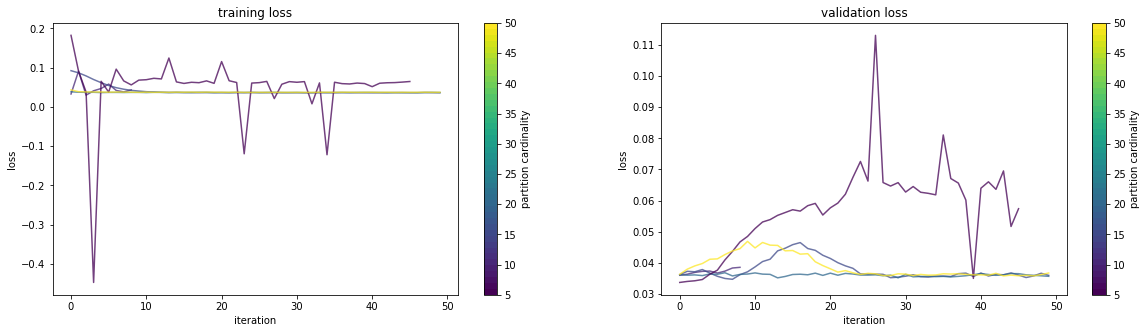

In [18]:
trained = glob(f'./history/splines_*')
w = [int(i.split('_')[-1].split('.')[0]) for i in trained]
n = len(trained)+1
viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, np.amax(w)-np.amin(w)+1))
newcmp = ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols=2,figsize=(20,5))

for j,i in enumerate(trained):
    
    v = np.load(i)
    axs[0].plot(v[0],alpha=0.75,color = colors[w[j]-np.amin(w)])
    axs[1].plot(v[1],alpha=0.75,color = colors[w[j]-np.amin(w)])
    
axs[0].set_title("training loss")
axs[1].set_title("validation loss")


axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[0],label='partition cardinality')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[1],label='partition cardinality')

    
plt.show()



# Results

# Results with first function

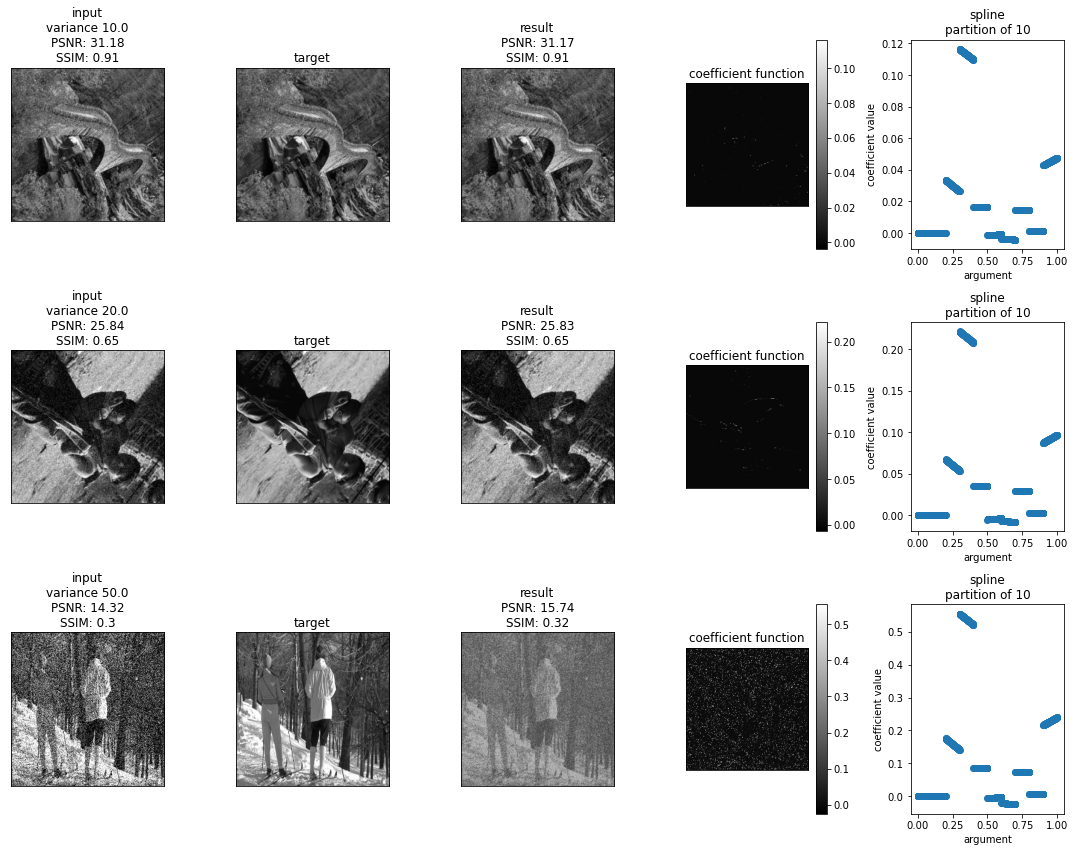

In [8]:
order = 1
num_classes = 10
model = get_model("splines",it_lim=1,image_size=image_size,num_classes = num_classes,order=order)
model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")

w = [10,20,50]
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(15,4*len(w)))
for i,m in enumerate(w):

    
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = next(gen_batch_val.as_numpy_iterator())
    p = model(ims[0])
    _ = np.random.choice(len(p))


    psnr_0 = tf.image.psnr(ims[0]['input'][_],ims[1][_],1).numpy()
    ssim_0 = tf.image.ssim(ims[0]['input'][_],ims[1][_],1).numpy()
    clean = p[_]
    psnr = tf.image.psnr(ims[1][_],clean,1).numpy()
    ssim = tf.image.ssim(ims[1][_],clean,1).numpy()
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline').output)
    spline = np.squeeze(get_lambdas(ims[0])[_])
    visualization = tf.keras.models.Model(model.input,model.get_layer('gS_0').output)
    vis = np.squeeze(visualization(ims[0])[_])


    psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
    psnr,ssim = int(100*psnr)/100,int(100*ssim)/100
    
    
    axs[i,0].imshow(ims[0]['input'][_],cmap='gray')
    axs[i,0].set_title(f'input\nvariance {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(ims[1][_],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(vis,cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
    partition = np.linspace(0,1,num_classes+1)
    x,s = [],[]


    for p in range(1,len(partition)):
        xp = np.linspace(partition[p-1],partition[p],100)
        linear = spline[p-1][1]*xp + spline[p-1][0]
        s.append(np.copy(linear))
        x.append(np.copy(xp))

    s = np.concatenate(s)
    x = np.concatenate(x)
    
    
    axs[i,4].scatter(x,s)
    axs[i,4].set_xlabel("argument")
    axs[i,4].set_ylabel("coefficient value")
    axs[i,4].set_title(f"spline\npartition of {num_classes}")
    
plt.tight_layout()
plt.show()

# Comparing against Perona Malik

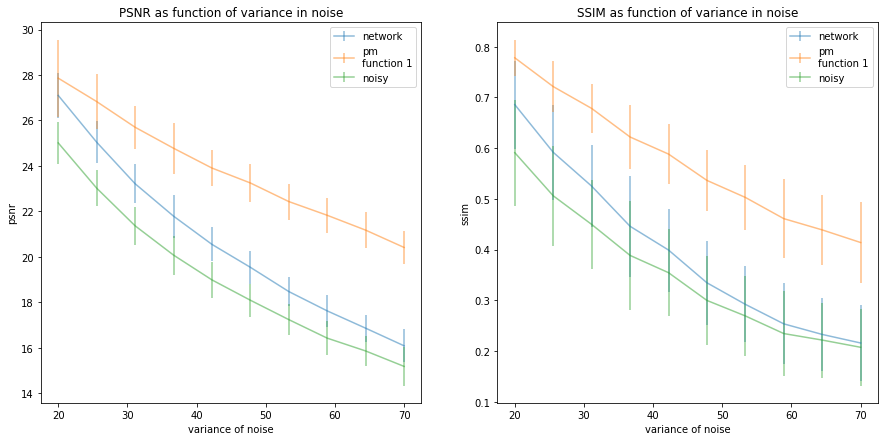

In [46]:
order = 1
num_classes = 50
model = get_model("splines",it_lim=1,image_size=image_size,num_classes = num_classes,order=order)
model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")

w = np.linspace(20,70,10)
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

psnr_or_1,psnr_or_s_1 = [],[]
ssim_or_1,ssim_or_s_1 = [],[]


for i,m in enumerate(w):
    gen_batch_train,gen_batch_val = get_generators('gaussian',0,w[i],CROP1=CROP,BATCH_SIZE=100)
    ims = next(gen_batch_val.as_numpy_iterator())
    
    res = model(ims[0]) 
    #res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
    psnr = tf.image.psnr(res,ims[1],1).numpy()
    ssim = tf.image.ssim(res,ims[1],1).numpy()
    #psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
    #ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_nn_1.append(np.mean(psnr))
    psnr_nn_s_1.append(np.std(psnr))
    ssim_nn_1.append(np.mean(ssim))
    ssim_nn_s_1.append(np.std(ssim))
    
    pm = np.array([anisodiff(im,niter = 5) for im in ims[0]['input']])
    pm = np.asarray(pm,dtype='float32')
    psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
    psnr_pm_1.append(np.mean(psnr))
    psnr_pm_s_1.append(np.std(psnr))
    ssim_pm_1.append(np.mean(ssim))
    ssim_pm_s_1.append(np.std(ssim))
    
    psnr = tf.image.psnr(ims[0]['input'],ims[1],1).numpy()
    ssim = tf.image.ssim(ims[0]['input'],ims[1],1).numpy()
    psnr_or_1.append(np.mean(psnr))
    psnr_or_s_1.append(np.std(psnr))
    ssim_or_1.append(np.mean(ssim))
    ssim_or_s_1.append(np.std(ssim))
    
    

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,psnr_or_1,psnr_or_s_1,label='noisy',alpha=0.5)

#plt.errorbar(w,psnr_nn_2,psnr_nn_s_2,label='network\nfunction 2',alpha=0.5)
#plt.errorbar(w,psnr_pm_2,psnr_pm_s_2,label='pm\nfunction 2',alpha=0.5)
plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,ssim_or_1,ssim_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

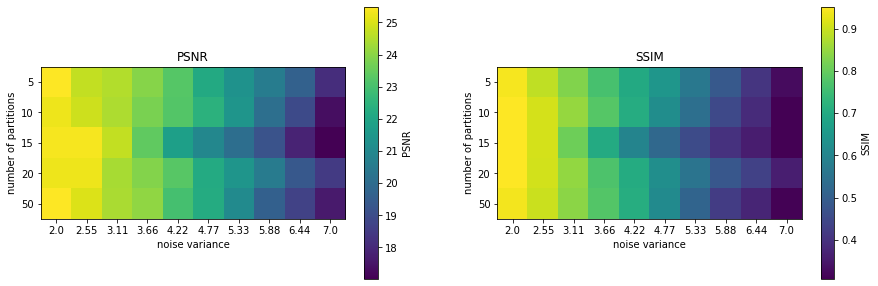

In [70]:
order = 1
w = np.linspace(2,7,10)
w = np.asarray(100*w,dtype='int')/100
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/splines_{typ}_*.index")])


hist_psnr,hist_ssim = [],[]

for num_classes in ncl:

    psnr_nn_1,ssim_nn_1 = [],[]
    model = get_model("splines",it_lim=1,image_size=image_size,num_classes = num_classes,order=order)
    for i,m in enumerate(w):
        
        model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")
        gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=100)
        ims = np.array(next(gen_batch_val.as_numpy_iterator()))

        res = model(ims[0])
        res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
        psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_nn_1.append(np.mean(psnr))
        ssim_nn_1.append(np.mean(ssim))


    hist_psnr.append(np.copy(psnr_nn_1))
    hist_ssim.append(np.copy(ssim_nn_1))
    

plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(hist_psnr)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('PSNR')
plt.colorbar(label='PSNR')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.subplot(122)
plt.imshow(hist_ssim)
plt.xlabel('noise variance')
plt.ylabel('number of partitions')
plt.title('SSIM')
plt.colorbar(label='SSIM')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.show()

# Analizing functions for coefficients

In [19]:
order = 1
w = np.linspace(2,10,20)
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/splines_{typ}_*.index")])
xR,R = [],[]

for num_classes in ncl:
    model = get_model("splines",it_lim=10,image_size=image_size,num_classes = num_classes,order=order)
    model.load_weights(f"./checkpoints/splines_{typ}_{num_classes}")
    R.append([])
    xR.append([])
    for i,m in enumerate(w):


        gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=100)
        ims = next(gen_batch_val.as_numpy_iterator())
        p = model(ims[0])
        _ = np.random.choice(len(p))


        psnr_0 = tf.image.psnr(ims[0]['input'][_],ims[1][_],1).numpy()
        ssim_0 = tf.image.ssim(ims[0]['input'][_],ims[1][_],1).numpy()
        clean = p[_]
        psnr = tf.image.psnr(ims[1][_],clean,1).numpy()
        ssim = tf.image.ssim(ims[1][_],clean,1).numpy()
        clean = np.squeeze(clean)
        inputs = tf.keras.Input(shape=image_size + (1,))
        get_lambdas = tf.keras.models.Model(model.input,model.get_layer('coeff_spline_0').output)
        spline = np.squeeze(get_lambdas(ims[0]))
        spline = np.mean(spline,axis=0)

        partition = np.linspace(0,1,num_classes+1)
        x,s = [],[]


        for p in range(1,len(partition)):
            xp = np.linspace(partition[p-1],partition[p],100)
            linear = spline[p-1][1]*xp + spline[p-1][0]
            s.append(np.copy(linear))
            x.append(np.copy(xp))

        s = np.concatenate(s)
        x = np.concatenate(x)
    
    
        R[-1].append(np.copy(s))
        xR[-1].append(np.copy(x))

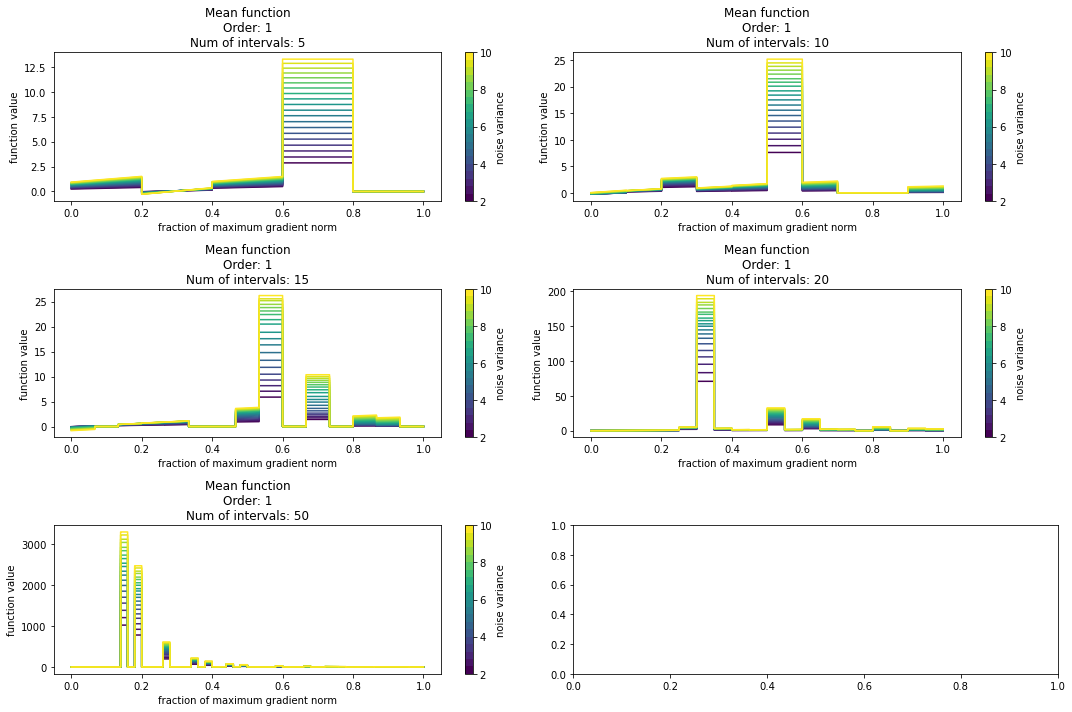

In [21]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = 2,nrows = 3,figsize=(15,10))

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        #m,s = R[col][i].T

        #axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])
        axs[col//2,col%2].plot(xR[col][i],R[col][i],color=colors[i])

    axs[col//2,col%2].set_title(f"Mean function\nOrder: {1}\nNum of intervals: {ncl[col]}")
    axs[col//2,col%2].set_xlabel("fraction of maximum gradient norm")
    axs[col//2,col%2].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col//2,col%2],label='noise variance')

plt.tight_layout()        
plt.show()

# Plot the model

In [6]:
order = 1
model = get_model("splines",it_lim=1,image_size=image_size,num_classes = 5,order=order)

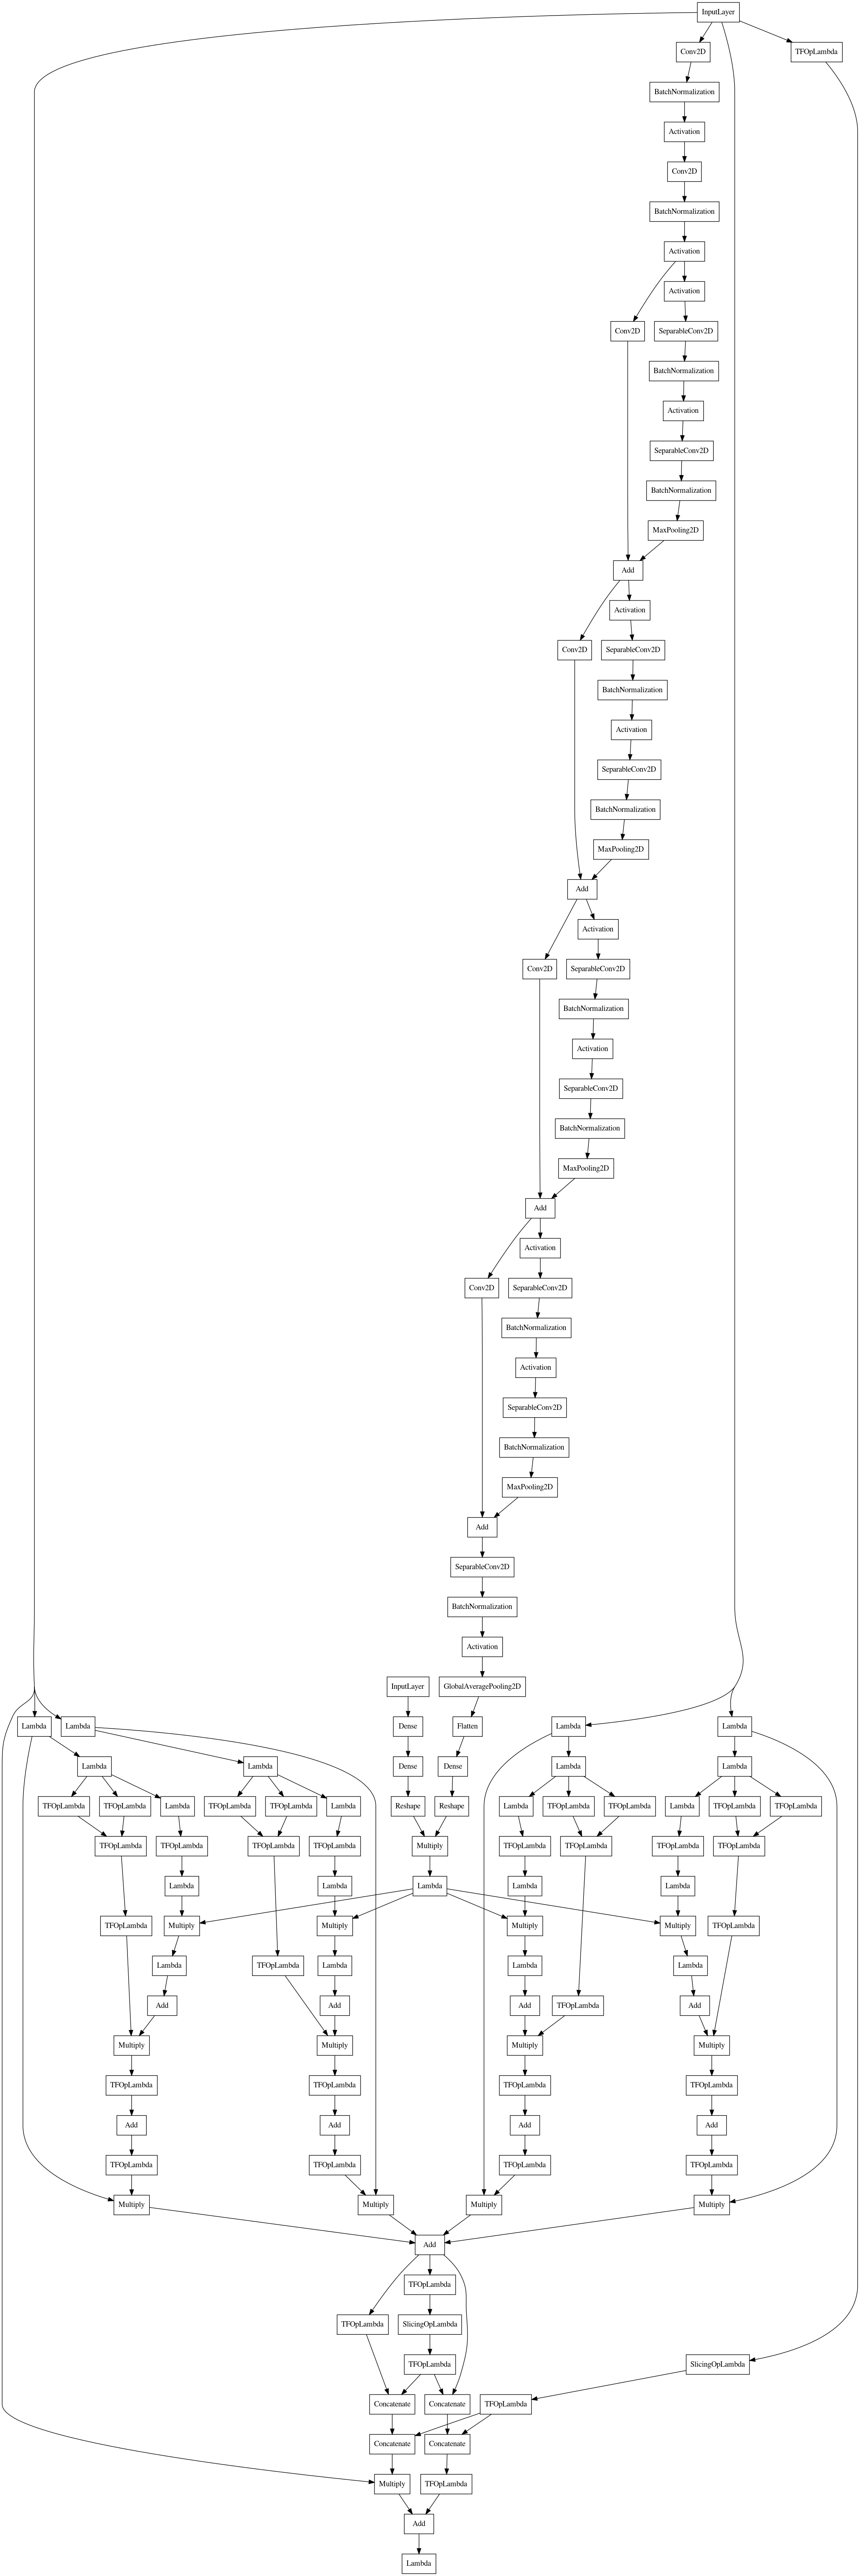

In [7]:
tf.keras.utils.plot_model(model,
    to_file="splines.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,)